In [420]:
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiLineString
import networkx as nx
import pickle
import queue
import random

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

In [212]:
# Forecasts
day1_forecast = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day1/day1_forecasts.geojson')

In [213]:
random_color = lambda: np.random.random(3)

In [214]:
# look at the forecasts
day1_forecast

,prediction,forecastHour,datetime,maxWinds,category,geometry
0,1,12,2021-07-28T08:00:00,70,1,POINT (-69.75497 37.90491)
1,1,24,2021-07-28T20:00:00,75,1,POINT (-70.50738 38.86856)
2,1,36,2021-07-29T08:00:00,85,2,POINT (-71.35866 39.41313)
3,1,48,2021-07-29T20:00:00,85,2,POINT (-71.72152 40.51758)
4,1,60,2021-07-30T08:00:00,100,3,POINT (-71.48969 41.18486)
...,...,...,...,...,...,...
155,20,48,2021-07-29T20:00:00,85,2,POINT (-71.49297 40.27587)
156,20,60,2021-07-30T08:00:00,100,3,POINT (-70.95934 42.12895)
157,20,72,2021-07-30T20:00:00,105,3,POINT (-71.61717 40.70945)
158,20,96,2021-07-31T20:00:00,90,2,POINT (-70.44554 43.65152)


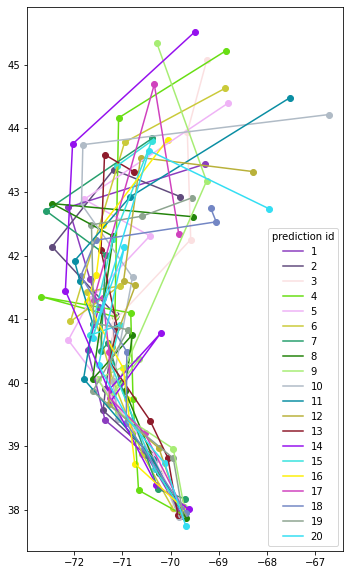

In [216]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for pred_id, pred in day1_forecast.groupby('prediction'):
    c = random_color()
    pred.plot(color=c, ax=ax)
    line_to_plot = LineString(pred.geometry.values)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
ax.legend(title='prediction id')

<AxesSubplot:>

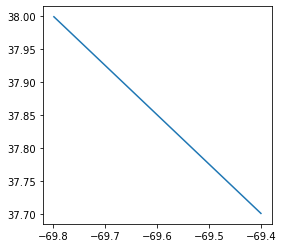

In [17]:
# track shows where the storm actually went in the past
day1_track = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day1/day1_track_past.geojson')
day1_track.plot()

# Game Grid
This is the grid that represents the scope of the response, and also the transportation network
It uses the [Military Grid Reference System](https://en.wikipedia.org/wiki/Military_Grid_Reference_System) to divide the world into a grid. There is a unique alphanumeric string that identifies each cell. We are working at the 1km resolution of the grid. See also the [US National Grid](https://www.fgdc.gov/usng/how-to-read-usng) which is nearly identical, except for some [edge-cases](https://www.maptools.com/tutorials/mgrs_usng_diffs).

In [306]:
# downloading pre-hurricane game grid (pretty big file ~ 111 MB)
!wget https://files.bwsi-remote-sensing.net/data/final/game_grid_2021_post_event.geojson

--2021-07-30 23:14:22--  https://files.bwsi-remote-sensing.net/data/final/game_grid_2021_post_event.geojson
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 44.240.92.60, 52.35.185.79, 52.42.113.200, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|44.240.92.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105629485 (101M)
Saving to: ‘game_grid_2021_post_event.geojson’

game_grid_2021_post 100%[===================>] 100.74M   166MB/s    in 0.6s    

2021-07-30 23:14:23 (166 MB/s) - ‘game_grid_2021_post_event.geojson’ saved [105629485/105629485]



In [307]:
game_grid = gpd.read_file('game_grid_2021_post_event.geojson')
game_grid = game_grid.drop_duplicates(subset=['MGRS'])

In [308]:
game_grid = game_grid.reset_index().drop(['index'], axis=1)
game_grid

,MGRS,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS_10km,transport_score,DN,wind_speed,geometry
0,18TWL8392,583000mE,4592000mN,WL,18T,400000.000000,18TWL89,1.0,NaN,None,"POLYGON ((-73.99395 41.47521, -74.00593 41.475..."
1,18TWL8393,583000mE,4593000mN,WL,18T,400000.000000,18TWL89,0.1,7.0,None,"POLYGON ((-73.99381 41.48421, -74.00579 41.484..."
2,18TWL8394,583000mE,4594000mN,WL,18T,400000.000000,18TWL89,0.2,7.0,None,"POLYGON ((-73.99367 41.49322, -74.00565 41.493..."
3,18TWL8395,583000mE,4595000mN,WL,18T,400000.000000,18TWL89,0.3,8.0,None,"POLYGON ((-73.99354 41.50222, -74.00552 41.502..."
4,18TWL8396,583000mE,4596000mN,WL,18T,400000.000000,18TWL89,10.0,2.0,None,"POLYGON ((-73.99340 41.51123, -74.00538 41.511..."
...,...,...,...,...,...,...,...,...,...,...,...
196817,19TFL4402,644000mE,5002000mN,FL,19T,0.043441,19TFL40,1.0,NaN,TS,"POLYGON ((-67.15522 45.15658, -67.16794 45.156..."
196818,19TFL4500,645000mE,5000000mN,FL,19T,0.043433,19TFL40,0.9,NaN,TS,"POLYGON ((-67.14309 45.13838, -67.15580 45.138..."
196819,19TFL4501,645000mE,5001000mN,FL,19T,0.043437,19TFL40,0.9,NaN,TS,"POLYGON ((-67.14280 45.14738, -67.15551 45.147..."
196820,19TFL4502,645000mE,5002000mN,FL,19T,0.043441,19TFL40,1.0,NaN,TS,"POLYGON ((-67.14251 45.15637, -67.15522 45.156..."


<AxesSubplot:>

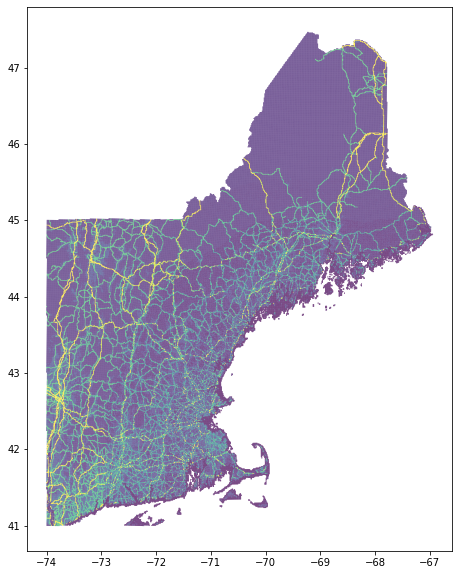

In [309]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
game_grid.plot(column='transport_score', ax=ax)

In [310]:
game_grid_copy = game_grid.copy()
game_grid_copy['geometry'] = game_grid.to_crs('epsg:3857').buffer(10).to_crs('epsg:4326')
game_grid_copy

,MGRS,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS_10km,transport_score,DN,wind_speed,geometry
0,18TWL8392,583000mE,4592000mN,WL,18T,400000.000000,18TWL89,1.0,NaN,None,"POLYGON ((-73.99386 41.47520, -73.99386 41.475..."
1,18TWL8393,583000mE,4593000mN,WL,18T,400000.000000,18TWL89,0.1,7.0,None,"POLYGON ((-73.99372 41.48421, -73.99372 41.484..."
2,18TWL8394,583000mE,4594000mN,WL,18T,400000.000000,18TWL89,0.2,7.0,None,"POLYGON ((-73.99358 41.49322, -73.99359 41.493..."
3,18TWL8395,583000mE,4595000mN,WL,18T,400000.000000,18TWL89,0.3,8.0,None,"POLYGON ((-73.99345 41.50222, -73.99345 41.502..."
4,18TWL8396,583000mE,4596000mN,WL,18T,400000.000000,18TWL89,10.0,2.0,None,"POLYGON ((-73.99331 41.51123, -73.99331 41.511..."
...,...,...,...,...,...,...,...,...,...,...,...
196817,19TFL4402,644000mE,5002000mN,FL,19T,0.043441,19TFL40,1.0,NaN,TS,"POLYGON ((-67.15513 45.15658, -67.15513 45.156..."
196818,19TFL4500,645000mE,5000000mN,FL,19T,0.043433,19TFL40,0.9,NaN,TS,"POLYGON ((-67.14300 45.13838, -67.14300 45.138..."
196819,19TFL4501,645000mE,5001000mN,FL,19T,0.043437,19TFL40,0.9,NaN,TS,"POLYGON ((-67.14271 45.14737, -67.14271 45.147..."
196820,19TFL4502,645000mE,5002000mN,FL,19T,0.043441,19TFL40,1.0,NaN,TS,"POLYGON ((-67.14242 45.15637, -67.14242 45.156..."


In [311]:
edges = gpd.sjoin(game_grid, game_grid_copy, how='inner', op='intersects')
edges

,MGRS_left,EASTING_left,NORTHING_left,kmSQ_ID_left,GZD_left,Shape_Leng_left,MGRS_10km_left,transport_score_left,DN_left,wind_speed_left,...,MGRS_right,EASTING_right,NORTHING_right,kmSQ_ID_right,GZD_right,Shape_Leng_right,MGRS_10km_right,transport_score_right,DN_right,wind_speed_right
0,18TWL8392,583000mE,4592000mN,WL,18T,400000.000000,18TWL89,1.0,NaN,None,...,18TWL8491,584000mE,4591000mN,WL,18T,400000.000000,18TWL89,1.0,5.0,None
59,18TWL8490,584000mE,4590000mN,WL,18T,400000.000000,18TWL89,0.1,6.0,None,...,18TWL8491,584000mE,4591000mN,WL,18T,400000.000000,18TWL89,1.0,5.0,None
60,18TWL8491,584000mE,4591000mN,WL,18T,400000.000000,18TWL89,1.0,5.0,None,...,18TWL8491,584000mE,4591000mN,WL,18T,400000.000000,18TWL89,1.0,5.0,None
61,18TWL8492,584000mE,4592000mN,WL,18T,400000.000000,18TWL89,0.1,7.0,None,...,18TWL8491,584000mE,4591000mN,WL,18T,400000.000000,18TWL89,1.0,5.0,None
120,18TWL8590,585000mE,4590000mN,WL,18T,400000.000000,18TWL89,7.0,NaN,None,...,18TWL8491,584000mE,4591000mN,WL,18T,400000.000000,18TWL89,1.0,5.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196821,19TFL4600,646000mE,5000000mN,FL,19T,0.043432,19TFL40,0.1,9.0,TS,...,19TFL4501,645000mE,5001000mN,FL,19T,0.043437,19TFL40,0.9,NaN,TS
196816,19TFL4401,644000mE,5001000mN,FL,19T,0.043437,19TFL40,0.9,NaN,TS,...,19TFL4502,645000mE,5002000mN,FL,19T,0.043441,19TFL40,1.0,NaN,TS
196817,19TFL4402,644000mE,5002000mN,FL,19T,0.043441,19TFL40,1.0,NaN,TS,...,19TFL4502,645000mE,5002000mN,FL,19T,0.043441,19TFL40,1.0,NaN,TS
196819,19TFL4501,645000mE,5001000mN,FL,19T,0.043437,19TFL40,0.9,NaN,TS,...,19TFL4502,645000mE,5002000mN,FL,19T,0.043441,19TFL40,1.0,NaN,TS


In [312]:
graph = nx.Graph()
for i, r in game_grid.iterrows():
    graph.add_node(r['MGRS'])

In [313]:
count = 0
for i, r in edges.iterrows():
    if(count % 100000 == 0):
        print(count)
    
    node1 = r['MGRS_left']
    node2 = r['MGRS_right']

    edge_weight = 20. / (r['transport_score_left'] + r['transport_score_right'])
    if(node1 != node2):
        graph.add_edge(node1, node2, weight=edge_weight)
    count += 1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [314]:
len(graph.edges())

779895

In [315]:
len(graph.nodes())

196822

In [316]:
w,s,e,n = game_grid.total_bounds
print(w,s,e,n)

-74.0062751207002 40.995556258214776 -66.93832921282291 47.46624330268622


In [320]:
hospitals_url = 'Hospitals.csv'
hospitals_df = pd.read_csv(hospitals_url)

In [321]:
hospitals_df = hospitals_df.fillna('')
hospitals_df = hospitals_df.loc[(hospitals_df['X']>= -74.0062751207002) & (hospitals_df['X']<= -66.93832921282291) & (hospitals_df['Y'] >= 40.995556258214776) & (hospitals_df['Y'] <= 47.46624330268622)]
hospitals_df = hospitals_df.reset_index().drop(['index'], axis=1)
hospitals_df

,X,Y,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,VAL_DATE,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD
0,-72.740616,41.701686,8594,3606111,VA MEDICAL CENTER - NEWINGTON CAMPUS,555 WILLARD AVE,NEWINGTON,CT,6111,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.connecticut.va.gov/,NOT AVAILABLE,NOT AVAILABLE,9.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
1,-71.053936,42.063022,8601,6002401,VA MEDICAL CENTER - BROCKTON DIVISION,940 BELMONT ST,BROCKTON,MA,2401,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.boston.va.gov/,NOT AVAILABLE,NOT AVAILABLE,25.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
2,-72.682440,42.349531,8602,6901062,VA CENTRAL WESTERN MASSACHUSETTS HEALTHCARE SY...,421 N MAIN ST,NORTHAMPTON,MA,1062,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.centralwesternmass.va.gov/,NOT AVAILABLE,NOT AVAILABLE,25.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
3,-71.171698,42.274627,8603,6802132,VA MEDICAL CENTER - WEST ROXBURY DIVISION,1400 VFW PKY,WEST ROXBURY,MA,2132,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.boston.va.gov/,NOT AVAILABLE,NOT AVAILABLE,25.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
4,-71.440867,43.012358,8613,9103104,VA MEDICAL CENTER - MANCHESTER,718 SMYTH RD,MANCHESTER,NH,3104,NOT AVAILABLE,...,2018-05-15T00:00:00.000Z,http://www.manchester.va.gov/,NOT AVAILABLE,NOT AVAILABLE,33.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,-72.009558,44.445787,7703,905819,NORTHEASTERN VERMONT REGIONAL HOSPITAL,1315 HOSPITAL DR,ST. JOHNSBURY,VT,5819,NOT AVAILABLE,...,2018-01-19T00:00:00.000Z,http://www.nvrh.org,E23931,NOT AVAILABLE,50.0,NON-PROFIT,-999.0,25.0,NOT AVAILABLE,Y
342,-71.480809,44.904447,7704,2503576,UPPER CONNECTICUT VALLEY HOSPITAL,181 CORLISS LANE,COLEBROOK,NH,3576,NOT AVAILABLE,...,2018-02-16T00:00:00.000Z,http://www.ucvh.org,NOT AVAILABLE,NOT AVAILABLE,33.0,NON-PROFIT,-999.0,16.0,NOT AVAILABLE,NOT AVAILABLE
343,-71.554340,44.486230,7705,2703584,WEEKS MEDICAL CENTER,173 MIDDLE STREET,LANCASTER,NH,3584,NOT AVAILABLE,...,2018-02-16T00:00:00.000Z,http://www.weeksmedical.org,NOT AVAILABLE,NOT AVAILABLE,33.0,NON-PROFIT,-999.0,25.0,NOT AVAILABLE,NOT AVAILABLE
344,-73.803656,42.655968,7767,112208,ST. PETER'S HOSPITAL,315 S MANNING BLVD,ALBANY,NY,12208,NOT AVAILABLE,...,2017-12-22T00:00:00.000Z,http://www.sphcs.org,0101004H,NOT AVAILABLE,36.0,NON-PROFIT,-999.0,442.0,NOT AVAILABLE,NOT AVAILABLE


In [326]:
loc_gdf = GeoDataFrame()
loc_gdf['geometry'] = None
loc_gdf['resources'] = None
for i, r in hospitals_df.iterrows():
    h_point = Point(r['X'], r['Y'])
    loc_gdf.loc[i] = [h_point, 500]
loc_gdf = loc_gdf.set_crs(epsg=4326)
loc_gdf

,geometry,resources
0,POINT (-72.74062 41.70169),500
1,POINT (-71.05394 42.06302),500
2,POINT (-72.68244 42.34953),500
3,POINT (-71.17170 42.27463),500
4,POINT (-71.44087 43.01236),500
...,...,...
341,POINT (-72.00956 44.44579),500
342,POINT (-71.48081 44.90445),500
343,POINT (-71.55434 44.48623),500
344,POINT (-73.80366 42.65597),500


In [328]:
a_hos = gpd.read_file('additional_hospitals_to_supply.geojson')
shelters = gpd.read_file('additional_shelters_to_supply.geojson')
for i, r in a_hos.iterrows():
    loc_gdf.loc[len(loc_gdf)] = [r['geometry'], 500]
for i, r in shelters.iterrows():
    loc_gdf.loc[len(loc_gdf)] = [r['geometry'], r['EVACUATION_CAPACITY'] * 5]
loc_gdf

,geometry,resources
0,POINT (-72.74062 41.70169),500
1,POINT (-71.05394 42.06302),500
2,POINT (-72.68244 42.34953),500
3,POINT (-71.17170 42.27463),500
4,POINT (-71.44087 43.01236),500
...,...,...
1510,POINT (-70.27778 43.65585),30000.0
1511,POINT (-70.83230 43.03431),2475.0
1512,POINT (-71.32315 42.07846),250.0
1513,POINT (-71.19249 42.31363),26620.0


In [330]:
dist = [Point(-71.19777777777779, 42.00083333333333), Point(-72.53478430555555, 42.19401497222222), Point(-71.54674869444445, 44.26406408333333)]
for point in dist:
    loc_gdf.loc[len(loc_gdf)] = [point, 0]
loc_gdf

,geometry,resources
0,POINT (-72.74062 41.70169),500
1,POINT (-71.05394 42.06302),500
2,POINT (-72.68244 42.34953),500
3,POINT (-71.17170 42.27463),500
4,POINT (-71.44087 43.01236),500
...,...,...
1513,POINT (-71.19249 42.31363),26620.0
1514,POINT (-71.51607 42.94571),250.0
1515,POINT (-71.19778 42.00083),0
1516,POINT (-72.53478 42.19401),0


In [331]:
joined_loc = gpd.sjoin(loc_gdf, game_grid, how='inner', op='within')
joined_loc = joined_loc.reset_index().drop(['index'], axis=1)
joined_loc

,geometry,resources,index_right,MGRS,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS_10km,transport_score,DN,wind_speed
0,POINT (-72.74062 41.70169),500,21471,18TXM8719,687000mE,4619000mN,XM,18T,400000.000000,18TXM81,2.10,NaN,STS
1,POINT (-72.74062 41.70169),500,21471,18TXM8719,687000mE,4619000mN,XM,18T,400000.000000,18TXM81,2.10,NaN,STS
2,POINT (-71.05394 42.06302),500,92012,19TCG3058,330000mE,4658000mN,CG,19T,0.042172,19TCG35,2.10,NaN,STS
3,POINT (-71.05394 42.06302),500,92012,19TCG3058,330000mE,4658000mN,CG,19T,0.042172,19TCG35,2.10,NaN,STS
4,POINT (-72.68244 42.34953),500,21843,18TXM9091,690000mE,4691000mN,XM,18T,400000.000000,18TXM99,3.43,NaN,STS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,POINT (-70.27778 43.65585),30000.0,110971,19TCJ9634,396000mE,4834000mN,CJ,19T,0.042806,19TCJ93,0.10,13.0,Hurr
1513,POINT (-70.83230 43.03431),2475.0,100465,19TCH5066,350000mE,4766000mN,CH,19T,0.042551,19TCH56,0.35,9.0,Hurr
1514,POINT (-71.32315 42.07846),250.0,89740,19TCG0761,307000mE,4661000mN,CG,19T,0.042176,19TCG06,1.50,NaN,Hurr
1515,POINT (-71.19249 42.31363),26620.0,90940,19TCG1986,319000mE,4686000mN,CG,19T,0.042264,19TCG18,2.00,NaN,Hurr


In [442]:
joined_loc['resources'].sum()

2772470.0

In [351]:
def connect_one(i):
    if(i % 100 == 0):
        print(i)
    cur_sp = nx.single_source_dijkstra_path_length(graph, joined_loc.loc[i, 'MGRS'])
    row = np.zeros((len(joined_loc)))
    for i2, r2 in joined_loc.iterrows():
        try:
            row[i2] = cur_sp[r2['MGRS']]
        except:
            row[i2] = np.nan
    return row

In [352]:
from multiprocessing import Pool
with Pool(2) as p:
    output = p.map(connect_one, range(len(joined_loc)))

0
200
100
300
400
600
500
700
800
1000
900
1100
1200
1400
1300
1500


In [353]:
sp_mat = np.stack(output)
sp_mat.shape

(1517, 1517)

In [365]:
joined_loc['component'] = None
comp = 0
for i in range(len(sp_mat)):
    if(joined_loc.loc[i, 'component'] != None):
        continue
    for j in range(len(sp_mat)):
        if(not np.isnan(sp_mat[i, j])):
            joined_loc.loc[j, 'component'] = comp
    comp += 1

In [416]:
def plot_group(gdf, column=None):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    #game_grid.plot(column='transport_score', ax=ax)
    if(column is None):
        gdf.plot(ax=ax)
    else:
        gdf.plot(column=column, ax=ax)
    plt.show()

In [360]:
np.save('sp_mat.npy', sp_mat)

In [364]:
sp_mat = np.load('sp_mat.npy')

In [371]:
dist = list(joined_loc[joined_loc['resources'] == 0].index)
dist

[598, 600, 1516]

In [400]:
def closest_dist(i):
    min_time = np.Inf
    min_dist = -1
    for d in dist:
        if(sp_mat[i, d] < min_time):
            min_time = sp_mat[i, d]
            min_dist = d
    return min_dist

In [497]:
def time_route(r):
    
    resources_left = 10000
    time = 0
    
    for i in range(1, len(r)):
        prev = r[i - 1]
        cur = r[i]

        resource = joined_loc.loc[cur, 'resources']
        resources_left -= resource
        
        if(resources_left < 0):
            cd = closest_dist(prev)
            time += sp_mat[prev, cd] + sp_mat[cd, cur] + 60
            resources_left += 10000
        else:
            time += sp_mat[prev, cur]
        
        num_loads = resource // 2000
        if(num_loads % resource != 0):
            num_loads += 1
        
        time += num_loads * 20
        
    return time

In [498]:
def add_stations(r):
    
    resources_left = 10000
    newroute = [r[0]]
    
    for i in range(1, len(r)):
        prev = r[i - 1]
        cur = r[i]

        resource = joined_loc.loc[cur, 'resources']
        resources_left -= resource
        
        if(resources_left < 0):
            cd = closest_dist(prev)
            newroute.append(cd)
            resources_left += 10000

        newroute.append(cur)
        
    return newroute

In [499]:
def remove_stations(r):
    newr = []
    for i, node in enumerate(r):
        if((node not in dist) or i == 0):
            newr.append(node)
    return newr

In [500]:
def swap_routes(r1, r2, i, j):
    if(j < len(r2) - 1):
        newr1 = r1[:i + 1] + r2[j + 1:]
    else:
        newr1 = r1[:i + 1]
    if(i < len(r1) - 1):
        newr2 = r2[:j + 1] + r1[i + 1:]
    else:
        newr2 = r2[:j + 1] + r1[i + 1:]
    return newr1, newr2

In [501]:
def improve_routes(r1, r2):
    orig_dist = max(time_route(r1), time_route(r2))
    for i in range(len(r1)):
        for j in range(len(r2)):
            newr1, newr2 = swap_routes(r1, r2, i, j)
            cur_dist = max(time_route(newr1), time_route(newr2))
            if(cur_dist < orig_dist):
                return newr1, newr2
    return None, None

In [502]:
def plot_route(routes):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    for i, route in enumerate(routes):
        if(len(route) <= 1):
            continue
        linestr = LineString([joined_loc.loc[i, 'geometry'] for i in route])
        c = random_color()
        x, y = linestr.xy
        ax.plot(x, y, color=c)
    plt.show()

In [503]:
t = 50

In [526]:
# Add code to read in routes into variable 'paths'

In [ ]:
for i in range(t):
    paths[i] = remove_stations(paths[i])

In [524]:
iters = 10
for i in range(iters):
    for j in range(t):
        for k in range(t):
            if(j != k):
                r1, r2 = improve_routes(paths[j], paths[k])
                if(r1 != None and r2 != None):
                    paths[j] = r1
                    paths[k] = r2

In [ ]:
for i in range(t):
    paths[i] = add_stations(paths[i])
plot_route(paths)